In [1]:
import  pandas as pd
import re
from math import ceil
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read csv file
textData = pd.read_csv("Emotions_training.csv")

# showing data 
textData.head(5)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


# Data Pre-processing

Text column fits to be a **string** datatype which will enable us to perform string operations if needed in future for any analysis.

In [4]:
string_colms = {'text':'string'}
textData = textData.astype(string_colms)
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 250.1 KB


In [5]:
textData.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


As we see maximum integer value in **label** colume is **5** so **int8** datatype will be enough.

In [6]:
#converting datatype for the int column
textData['label'] = textData['label'].astype('int8')
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 140.8 KB


So,now datatype is fixed.

Moving further, there are certain required pre-rpocessing asked to be done in this project. These are as mentioned below : 
- Covert to Lower Case
- Remove links
- Remove next lines (\n)
- Remove Words containing numbers
- Remove Extra spaces
- Remove Special characters

While perfoming above data-perprocessing the impact was not clearly visible as we did not know what rows are getting refactored. So,firstly let's check upon the impact of performing these on the rows of dataset we have.

In [7]:
# Find if upper case exists to be converted to lower case
rowsWithCapitalLetters = textData[textData['text'].str.islower() == False].shape[0]

# Find rows with links to be removed
rowsWithLinks = textData[textData['text'].str.contains(r'https?://[^\s]+')].shape[0]

# Find rows with newlines to be removed
rowsWithNewLine = textData[textData['text'].str.contains('\n')].shape[0]

# Find rows with special characters to be removed
def has_special_chars(text):
    for char in text:
        if not char.isalnum() and char not in [' ']: # It can also be new line but its zero as well :)
            return True
    return False

rowsWithSpChar = textData[textData['text'].apply(has_special_chars)].shape[0]

# Find rows with alphanumeric characters to be removed
def has_alnum(text):
    for char in text:
        if char.isnumeric():
            return True
    return False

rowsWithNum = textData[textData['text'].apply(has_alnum)].shape[0]

# Find rows with extra spaces to be removed
def has_extra_spaces(text):
    return '  ' in text

rowsWithExSpc = textData[textData['text'].apply(has_extra_spaces)].shape[0]

print(rowsWithCapitalLetters, 
      rowsWithLinks, 
      rowsWithNewLine, 
      rowsWithSpChar, 
      rowsWithNum, 
      rowsWithExSpc)

0 0 0 0 0 0


For the checks mentioned for the pre-processing, all the impacted rows were extracted into their respective dataframes and looked upon the count of rows impacted. Surprisingly, none of the rows had anything that would be altered even if these pre-processing steps were performed.
Therefore it is concluded that these pre-processing steps would have no change on the dataset.

However, while performing these, it was found that the text data has random words, weird songs, html tags, etc inserted to many of the sentences in text column making our data noisy. Below is one of the example :

In [8]:
# Finding occurance of random word in dataset
randomWords = textData[textData['text'].str.contains('http')] #https, href, a href http, www, etc
print(randomWords.shape)
randomWords.head(5)

(199, 2)


,text,label
125,i feel they are pretty safe on my blog img src...,1
323,i stopped feeling so exhausted a href http pro...,0
462,i feel so dazed a href http twitter,5
866,i feel unwelcome at work sometimes and think p...,0
967,i a href http feeling groggy,0


So, an attempt is being made to find and get rid of as much noise as possible by removing it.

In [9]:
# Define the substrings to remove
remove_strings = [' a href http ', ' http ', ' https ', ' www ', ' href ', ' src ', ' img ', ' s ']

# Iterate through each substring and remove it from the 'text' column in the main DataFrame
for substring in remove_strings:
    textData['text'] = textData['text'].str.replace(substring, ' ')

In [10]:
# Checking if it is removed for one as example
randomWords = textData[textData['text'].str.contains('http')] #http, href, a href http, www, etc
print(randomWords.shape)
randomWords.head(5)

(12, 2)


,text,label
1531,i definitely feel like hot stuff strutting dow...,2
2263,i do not know how to feel my hearts aching sad...,0
3170,i am feeling so festive right now and not just...,1
3231,im feeling my loving heart is all yours for th...,2
4986,im feeling determined to face facts have a gan...,1


#### Question : 
Above is not scalable way. How can we deal with such a scenerio efficiently ? 

In [11]:
# removing stop words
stop_words = set(stopwords.words('english'))
textData['text'] = textData['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
textData['text'] = textData['text'].astype('string') # as above operation changes it to object

In [12]:
# stemming
stemmer = PorterStemmer()
textData['text'] = textData['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


In [13]:
#lemmatization
lemmatizer = WordNetLemmatizer()
textData['text'] = textData['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
textData['text'] = textData['text'].astype('string') # as above operation changes it to object

In [14]:
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 140.8 KB


So we have completed with data-preprocessing.As we can see that before data-preprocessing the memory usage was **250.1+ KB** and after data-preprocessing the memory usage is **140.8 KB** it clearly show that memory usage is **reduced**.

### Class Distribution

Another important thing to make sure before feeding our data into the model is the class distribution of the data. In our case where the expected class are divided into six outcomes, 0 to 5, an equal class distribution can be considered ideal.

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


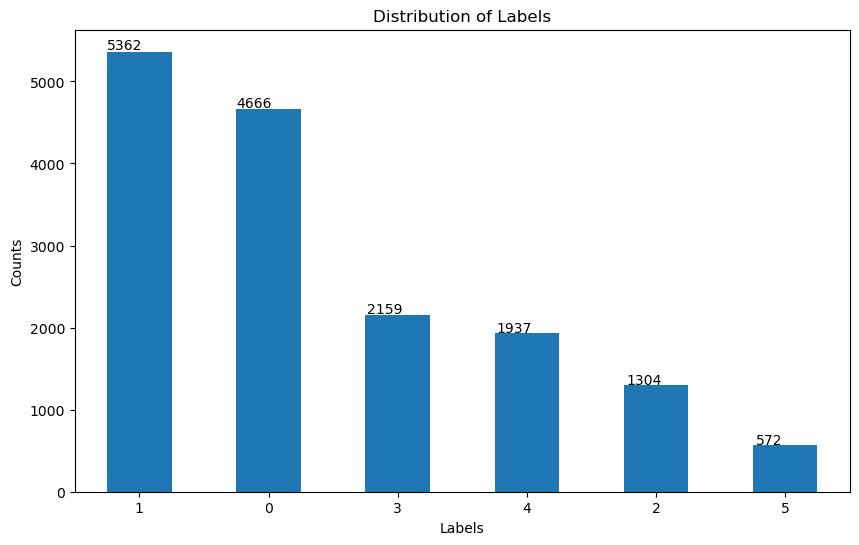

In [15]:
label_counts = textData['label'].value_counts()
print(label_counts)
plt.figure(figsize=(10, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)

# Adding the counts on top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

The dataset has an **imbalanced class distribution**. Classes 1 and 0 have significantly more samples than classes 3, 4, 2, and especially 5. This imbalance can affect the performance of the classification models, as they may become biased towards the more frequent classes.

#### Implications and Actions:

**Evaluation Metrics**: Instead of relying solely on **_accuracy_**, use evaluation metrics that account for class imbalance, such as **_precision_**, **_recall_**, **_F1-score_**, and the **_confusion matrix_**. These metrics will provide a more comprehensive understanding of model performance across all classes.

##### Resampling Techniques:

**Oversampling**: Increase the number of samples in the minority classes (e.g., using SMOTE - Synthetic Minority Over-sampling Technique).

**Undersampling**: Decrease the number of samples in the majority classes.

**Hybrid Methods**: Combine both oversampling and undersampling to balance the dataset.

**Class Weight Adjustment**: When training machine learning models, especially in algorithms like Logistic Regression and SVM, you can adjust the class weights to give more importance to the minority classes. This can be done using the class_weight parameter.

### Splitting Data

As we are building models, we will be dividing our data into 3 sections viz training, testing & validation. 

In [16]:
# Split into 70% training and 30% remaining
X_train, X_temp, y_train, y_temp = train_test_split(textData['text'], textData['label'], test_size=0.3, random_state=42)

# Split the remaining 30% into 20% testing and 10% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Verify the sizes
print(f'Training set: {len(X_train)} samples')
print(f'Testing set: {len(X_test)} samples')
print(f'Validation set: {len(X_val)} samples')

Training set: 11200 samples
Testing set: 3216 samples
Validation set: 1584 samples


### Vectorization Of Data

- Vectorization is essential for text classification tasks because machine learning algorithms typically require numerical input data. 
- Text data, being categorical and unstructured, needs to be converted into a numerical format that algorithms can process effectively. 
- Vectorization transforms text into numerical features, allowing machine learning models to learn patterns and make predictions based on the text's content.

We will be using TF-IDF technique of vectorization. TF-IDF, short for Term Frequency–Inverse Document Frequency, is a numerical statistic that is intended to reflect how important a word is to a document, in a collection or Corpus(Paragraph) as its value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

In [17]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

## Baadme sab likh lena

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       946
           1       0.91      0.85      0.88      1073
           2       0.66      0.84      0.74       296
           3       0.80      0.90      0.85       399
           4       0.83      0.81      0.82       380
           5       0.64      0.84      0.73       122

    accuracy                           0.85      3216
   macro avg       0.80      0.85      0.82      3216
weighted avg       0.86      0.85      0.85      3216

Accuracy: 0.8510572139303483


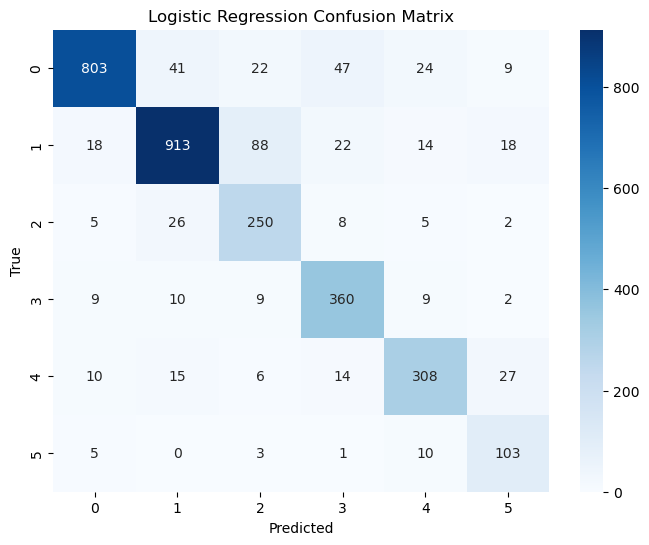

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Logistic Regression model
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42)
lr.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_tfidf)
y_pred_prob_lr = lr.predict_proba(X_test_tfidf)


# Evaluation
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr)}')
cm = confusion_matrix(y_test, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Support Vector Machine:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       946
           1       0.82      0.90      0.85      1073
           2       0.71      0.68      0.69       296
           3       0.81      0.83      0.82       399
           4       0.84      0.78      0.81       380
           5       0.72      0.60      0.65       122

    accuracy                           0.83      3216
   macro avg       0.80      0.77      0.78      3216
weighted avg       0.83      0.83      0.83      3216

Accuracy: 0.8289800995024875


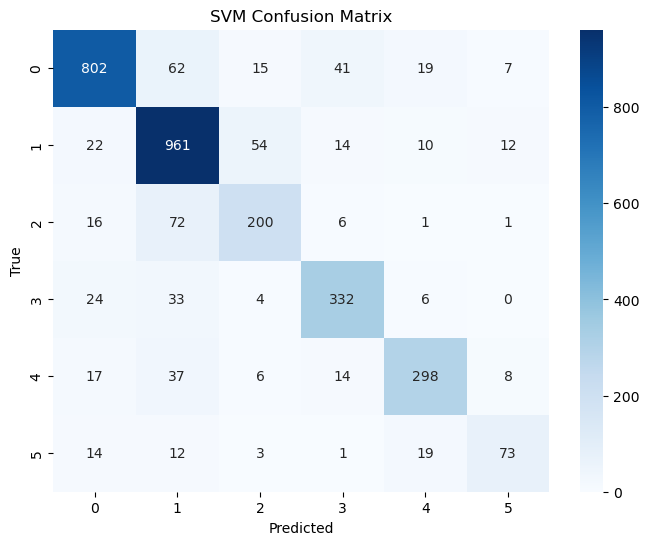

In [19]:
from sklearn.svm import SVC

# Train SVM model
svm = SVC(class_weight='balanced', random_state=42, probability=True)
svm.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm = svm.predict(X_test_tfidf)
y_pred_prob_svm = svm.predict_proba(X_test_tfidf)

# Evaluation
print("Support Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')
cm = confusion_matrix(y_test, y_pred_svm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Naive Bayes:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       946
           1       0.61      0.97      0.75      1073
           2       1.00      0.06      0.11       296
           3       0.90      0.39      0.54       399
           4       0.93      0.32      0.47       380
           5       1.00      0.01      0.02       122

    accuracy                           0.68      3216
   macro avg       0.86      0.44      0.45      3216
weighted avg       0.77      0.68      0.62      3216

Accuracy: 0.6831467661691543


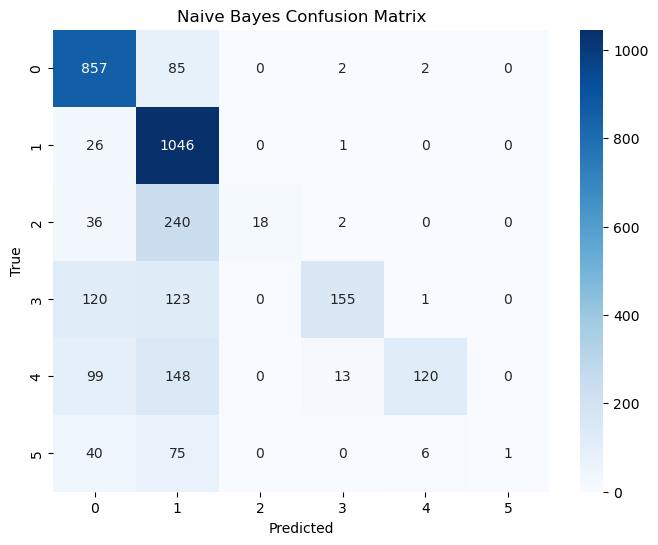

In [20]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predictions
y_pred_nb = nb.predict(X_test_tfidf)
y_pred_prob_nb = nb.predict_proba(X_test_tfidf)

# Evaluation
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb)}')
cm = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

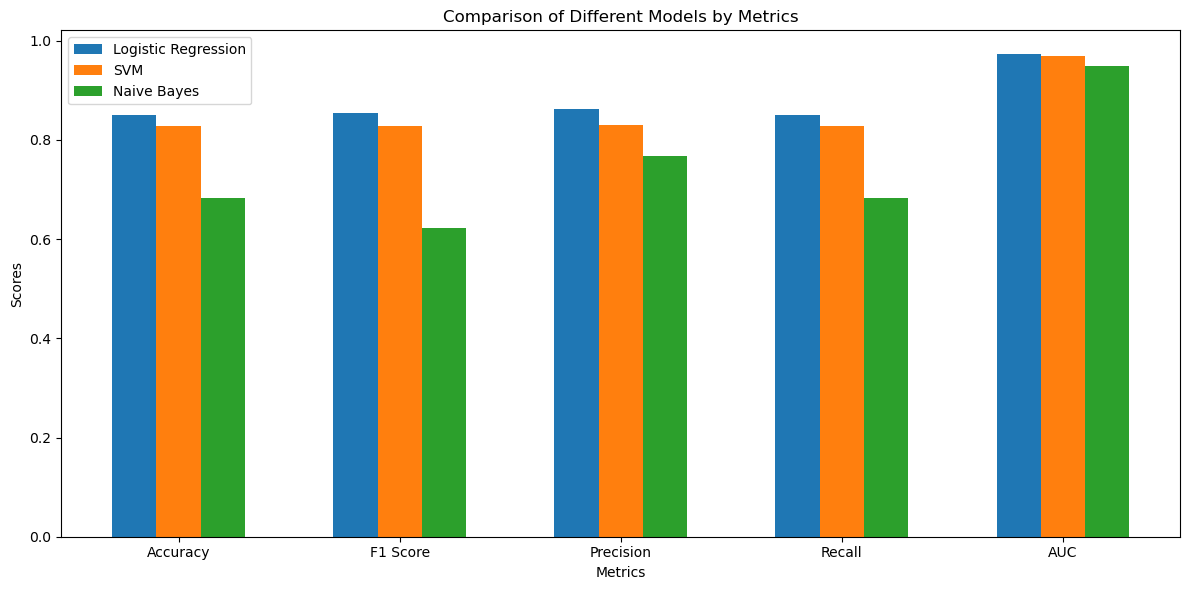

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Collecting metrics for comparison
models = ['Logistic Regression', 'SVM', 'Naive Bayes']
accuracies = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_nb)]
f1_scores = [f1_score(y_test, y_pred_lr, average='weighted'), f1_score(y_test, y_pred_svm, average='weighted'), f1_score(y_test, y_pred_nb, average='weighted')]
precisions = [precision_score(y_test, y_pred_lr, average='weighted'), precision_score(y_test, y_pred_svm, average='weighted'), precision_score(y_test, y_pred_nb, average='weighted')]
recalls = [recall_score(y_test, y_pred_lr, average='weighted'), recall_score(y_test, y_pred_svm, average='weighted'), recall_score(y_test, y_pred_nb, average='weighted')]
auc_scores = [roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_prob_lr, average='weighted', multi_class='ovr'),
              roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_prob_svm, average='weighted', multi_class='ovr'),
              roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_prob_nb, average='weighted', multi_class='ovr')]

# Data for plotting
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC']
values = [accuracies, f1_scores, precisions, recalls, auc_scores]
num_metrics = len(metrics)
num_models = len(models)

# Plotting the comparison
x = np.arange(num_metrics)  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each model's bar
for i in range(num_models):
    ax.bar(x + i * width, [values[j][i] for j in range(num_metrics)], width, label=models[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Models by Metrics')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()

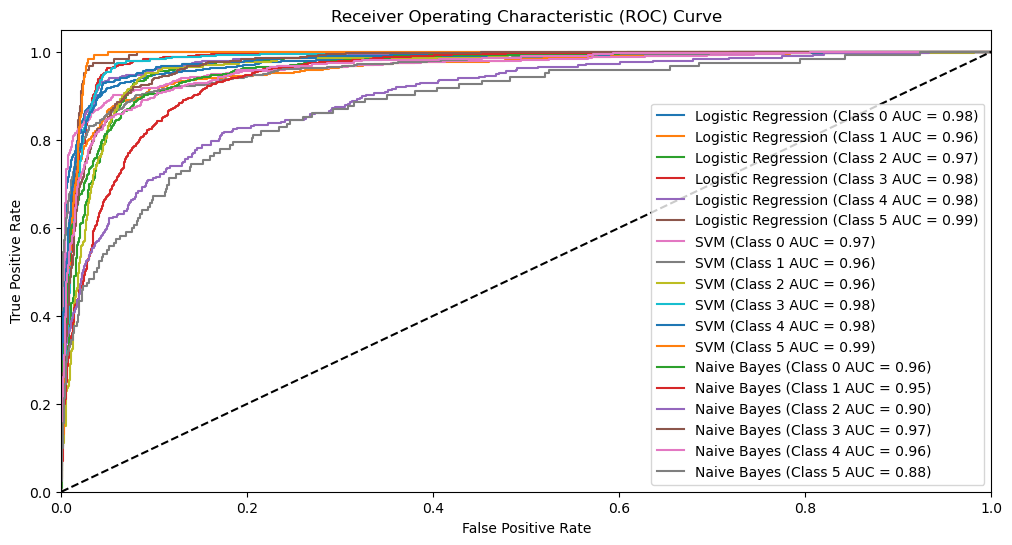

In [22]:
# Plotting ROC Curves
plt.figure(figsize=(12, 6))
for model_name, y_pred_prob in zip(models, [y_pred_prob_lr, y_pred_prob_svm, y_pred_prob_nb]):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(np.unique(y_train))):
        fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=np.unique(y_train))[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{model_name} (Class {i} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

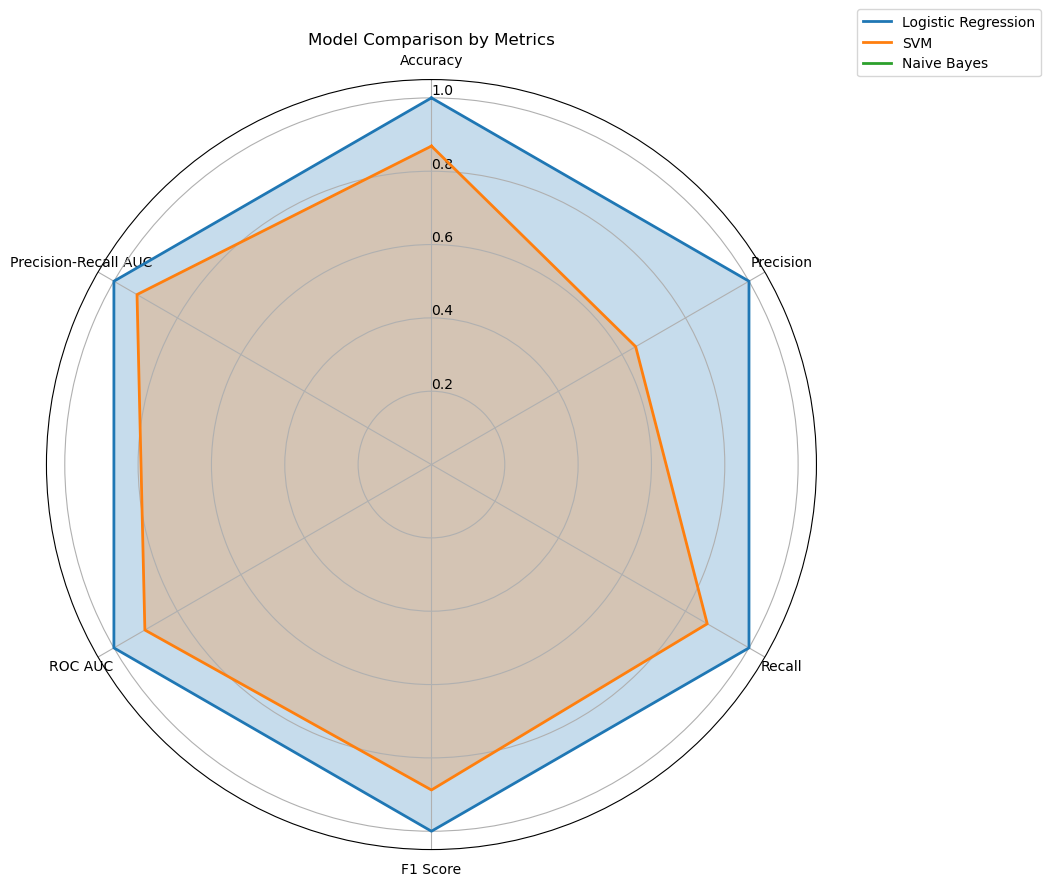

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Function to normalize values
def normalize(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

# Collecting metrics for comparison
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Precision-Recall AUC': []
}

# Compute metrics for each model
for model_name, y_pred, y_pred_prob in zip(models, [y_pred_lr, y_pred_svm, y_pred_nb], [y_pred_prob_lr, y_pred_prob_svm, y_pred_prob_nb]):
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))
    metrics['ROC AUC'].append(roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_prob, average='weighted', multi_class='ovr'))
    metrics['Precision-Recall AUC'].append(average_precision_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_prob, average='weighted'))

# Converting dictionary to numpy array for easier handling
metrics_names = list(metrics.keys())
num_metrics = len(metrics_names)
values = np.array([metrics[metric] for metric in metrics_names])

# Normalize values for better visualization
values = np.array([normalize(values[i]) for i in range(num_metrics)])

# Number of models
num_models = len(models)

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each model's data
for i, model in enumerate(models):
    data = values[:, i].tolist()
    data += data[:1]  # Complete the loop
    ax.plot(angles, data, label=model, linewidth=2)
    ax.fill(angles, data, alpha=0.25)

# Add some labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], metrics_names)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.title('Model Comparison by Metrics')
plt.show()

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Applying SMOTE and Tomek Links
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_resampled, y_resampled)

# Creating RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Grid Search for RandomForest hyperparameter tuning
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, scoring='f1_weighted', cv=5)
grid_search_rf.fit(X_resampled, y_resampled)

# Best RandomForest model
best_rf_clf = grid_search_rf.best_estimator_

# Creating XGBClassifier
xgb_clf = XGBClassifier(random_state=42)

# Grid Search for XGBClassifier hyperparameter tuning
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6]}
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='f1_weighted', cv=5)
grid_search_xgb.fit(X_resampled, y_resampled)

# Best XGBClassifier model
best_xgb_clf = grid_search_xgb.best_estimator_

# Voting Classifier (Ensemble of RandomForest and XGBClassifier)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('rf', best_rf_clf), ('xgb', best_xgb_clf)], voting='soft')
voting_clf.fit(X_resampled, y_resampled)

# Predictions
y_pred = voting_clf.predict(X_test_tfidf)
y_pred_prob = voting_clf.predict_proba(X_test_tfidf)[:, 1]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91       946
           1       0.89      0.88      0.88      1073
           2       0.74      0.74      0.74       296
           3       0.79      0.91      0.84       399
           4       0.84      0.85      0.85       380
           5       0.72      0.79      0.75       122

    accuracy                           0.86      3216
   macro avg       0.82      0.84      0.83      3216
weighted avg       0.86      0.86      0.86      3216

Accuracy: 0.8606965174129353


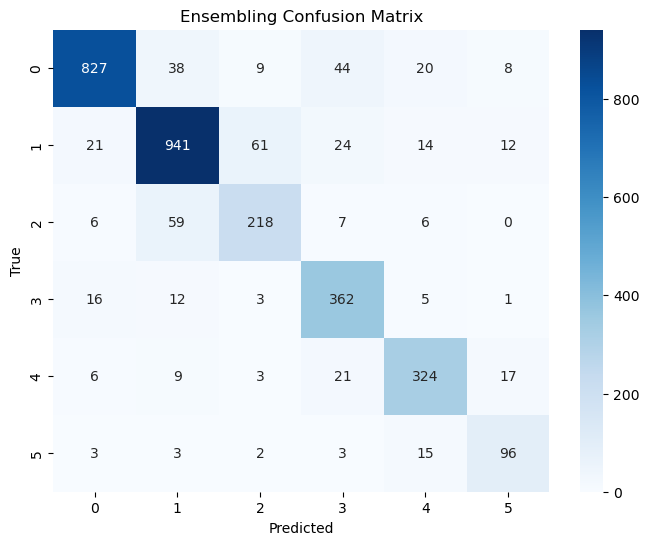

In [25]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensembling Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize individual models
log_reg = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg),
    ('svm', svm),
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_resampled, y_resampled)

# Predictions
y_pred = voting_clf.predict(X_test_tfidf)
y_pred_prob = voting_clf.predict_proba(X_test_tfidf)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       946
           1       0.88      0.90      0.89      1073
           2       0.77      0.70      0.73       296
           3       0.82      0.88      0.85       399
           4       0.83      0.84      0.83       380
           5       0.74      0.75      0.74       122

    accuracy                           0.86      3216
   macro avg       0.82      0.83      0.83      3216
weighted avg       0.86      0.86      0.86      3216

Accuracy: 0.861318407960199


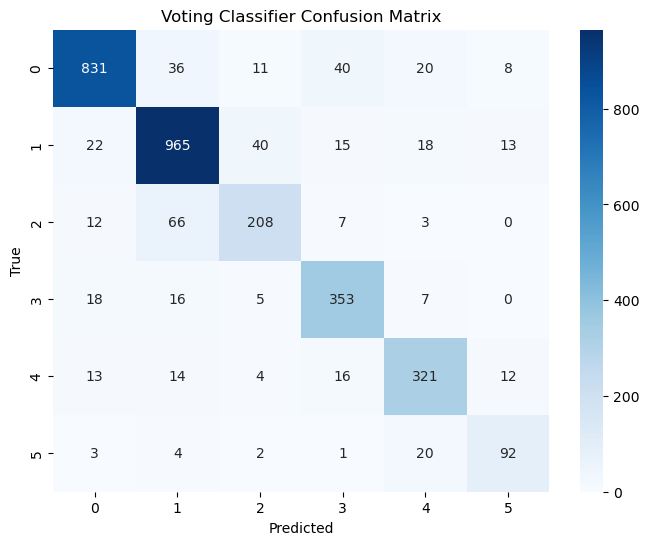

In [27]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Stacking Classifier Accuracy: 0.8510572139303483
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       946
           1       0.85      0.92      0.88      1073
           2       0.81      0.65      0.72       296
           3       0.82      0.86      0.84       399
           4       0.82      0.84      0.83       380
           5       0.84      0.46      0.59       122

    accuracy                           0.85      3216
   macro avg       0.84      0.77      0.79      3216
weighted avg       0.85      0.85      0.85      3216



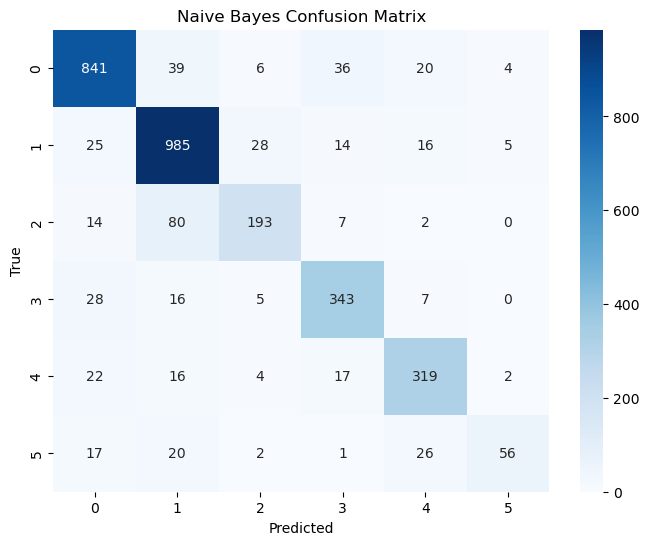

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', LogisticRegression()),
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier())
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_resampled, y_resampled)
y_pred = stacking_clf.predict(X_test_tfidf)

print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Stacking Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Stacking Classifier Accuracy: 0.8470149253731343
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       946
           1       0.84      0.92      0.88      1073
           2       0.82      0.55      0.66       296
           3       0.84      0.84      0.84       399
           4       0.82      0.84      0.83       380
           5       0.83      0.44      0.58       122

    accuracy                           0.85      3216
   macro avg       0.84      0.75      0.78      3216
weighted avg       0.85      0.85      0.84      3216



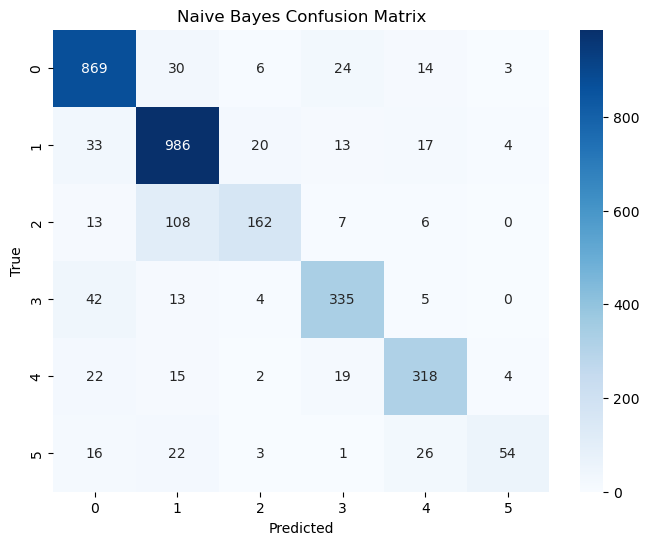

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', LogisticRegression()),
    ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier())
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
stacking_clf.fit(X_resampled, y_resampled)
y_pred = stacking_clf.predict(X_test_tfidf)

print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       946
           1       0.94      0.78      0.85      1073
           2       0.57      0.90      0.70       296
           3       0.76      0.92      0.83       399
           4       0.79      0.82      0.81       380
           5       0.62      0.89      0.73       122

    accuracy                           0.83      3216
   macro avg       0.77      0.85      0.80      3216
weighted avg       0.86      0.83      0.83      3216

Accuracy: 0.8274253731343284


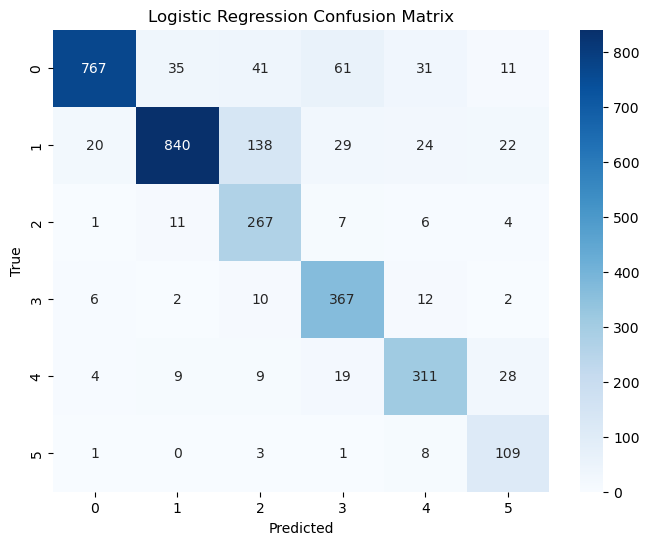

In [30]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Logistic Regression model
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42)
lr.fit(X_resampled, y_resampled)

# Predictions
y_pred_lr = lr.predict(X_test_tfidf)
y_pred_prob_lr = lr.predict_proba(X_test_tfidf)


# Evaluation
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr)}')
cm = confusion_matrix(y_test, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       946
           1       0.82      0.93      0.87      1073
           2       0.87      0.59      0.70       296
           3       0.84      0.84      0.84       399
           4       0.84      0.81      0.82       380
           5       0.78      0.67      0.72       122

    accuracy                           0.85      3216
   macro avg       0.84      0.79      0.81      3216
weighted avg       0.86      0.85      0.85      3216

Accuracy: 0.8535447761194029


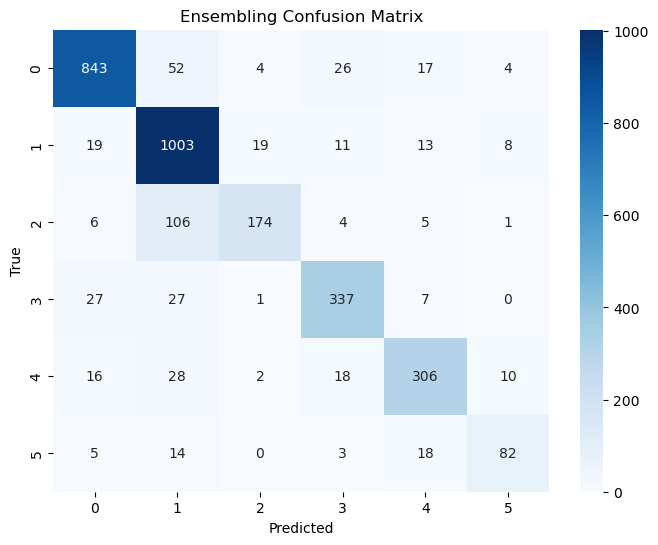

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Applying SMOTE and Tomek Links
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)
# tomek = TomekLinks()
# X_resampled, y_resampled = tomek.fit_resample(X_resampled, y_resampled)

# Creating RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Grid Search for RandomForest hyperparameter tuning
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, scoring='f1_weighted', cv=5)
grid_search_rf.fit(X_train_tfidf, y_train)

# Best RandomForest model
best_rf_clf = grid_search_rf.best_estimator_

# Creating XGBClassifier
xgb_clf = XGBClassifier(random_state=42)

# Grid Search for XGBClassifier hyperparameter tuning
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 6]}
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring='f1_weighted', cv=5)
grid_search_xgb.fit(X_train_tfidf, y_train)

# Best XGBClassifier model
best_xgb_clf = grid_search_xgb.best_estimator_

# Voting Classifier (Ensemble of RandomForest and XGBClassifier)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('rf', best_rf_clf), ('xgb', best_xgb_clf)], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = voting_clf.predict(X_test_tfidf)
y_pred_prob = voting_clf.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensembling Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()